# Optimization Homework 3 - LASSO
## Author: Clément Bonnet

In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
plt.style.use("seaborn")

Initial quadratic problem:
\begin{aligned}
    & \underset{v \in \mathrm{R}^n}{\text{minimize}}
    & & f(v) = v^TQv + p^Tv \\
    & \text{subject to}
    & & Av \preceq b
\end{aligned}

After including the log-barrier, the function $f_t$ to minimize now becomes:
\begin{equation*}
    f_t(v) = tv^TQv + tp^Tv - \sum_{k=1}^m \ln(b_k - (Av)_k) \\
\end{equation*}

One can derive its gradient $\nabla f_t$:
\begin{align*}
    \nabla f_t(v)_i &= 2t(Qv)_i + tp_i + \sum_{k=1}^m \frac{A_{k,i}}{b_k - (Av)_k} \\
    \nabla f_t(v) &= 2tQv + tp + A^T\gamma(v)
\end{align*}

With $\gamma(v)_k = \big[ b_k - (Av)_k \big]^{-1}$.

Finally, the hessian matrix follows from differentiating the gradient.
\begin{align*}
    \nabla^2 f_t(v)_{i,j} &= 2tQ_{i,j} + \sum_{k=1}^m \frac{A_{k,i}A_{k,j}}{(b_k - (Av)_k)^2} \\
    \nabla^2 f_t(v) &= 2tQ + A^TDA
\end{align*}

With $D = diag(\alpha_1,\cdots,\alpha_m)$ and $\alpha_k = \big[ b_k - (Av)_k \big]^{-2}$.

Once the optimal value $v^\star$ of the dual problem is found, one can recover the optimal solution $w^\star$ of the primal using the KKT conditions.
\begin{equation*}
    Xw^\star = y - v^\star
\end{equation*}

In [2]:
# Auxiliary functions

def in_domain(A, b, v):
    """
    Check whether v is in the domain of function f. If log can be defined.
    """
    return (b - A@v > 0).all()

def backtrack(Q, p, A, b, t, v0, eps, alpha, beta, step_dir, grad):
    """
    Backtracking line search.
    Return the right step_size for next update.
    """
    f_t = lambda v: t*v.T@Q@v + t*p.T@v - np.log(b - A@v).sum()
    v = v0.copy()
    step_size = 1
    backtrack_crit = False
    while not backtrack_crit:
        step_size *= beta
        if in_domain(A, b, v + step_size*step_dir):
            backtrack_crit = f_t(v + step_size*step_dir) < f_t(v) + alpha*step_size*grad.T@step_dir
    return step_size

In [3]:
def centering_step(Q, p, A, b, t, v0, eps, alpha, beta, verbose=False):
    """
    Centering step
    """    
    # Side effect on v
    v = v0
    seq = [v.copy()]
    center_crit = False
    while not center_crit:
        # Compute gradient and hessian matrix 
        grad = 2*t*Q@v + t*p + A.T@(1/(b - A@v))
        hess = 2*t*Q + A.T @ np.diag(1/((b - A@v)**2)) @ A
        # Newton step
        step_dir = np.linalg.solve(hess, -grad)
        # Newton decrement
        squared_decr = -grad.T @ step_dir
        center_crit = squared_decr/2 <= eps
        if verbose: print("Squared decrement:", squared_decr)
        if center_crit: break
        # Backtracking line search
        step_size = backtrack(Q, p, A, b, t, v0, eps, alpha, beta, step_dir, grad)
        v += step_size*step_dir
        seq.append(v.copy())
    return seq

In [4]:
def barr_method(Q, p, A, b, v0, eps, mu=10, t0=0.01, alpha=0.1, beta=0.5, verbose=False):
    """
    Barrier method to solve a quadratic program.
    Returns a sequence of values until the optimum.
    """
    t = t0
    m = A.shape[0]
    seq = []
    v = v0.copy()
    while m/t >= eps:
        t *= mu
        seq.extend(centering_step(Q, p, A, b, t, v, eps, alpha, beta, verbose))
    return seq

In [5]:
# To plot results

def print_plot(seq, Q, p, mu=None, color=None):
    f = lambda v: v.T@Q@v + p.T@v
    v_star = seq[-1]
    to_plot = [f(seq_i)-f(v_star) for seq_i in seq[:-1]]
    plt.step(range(len(to_plot)), to_plot, label="mu = {}".format(mu), color=color);
    plt.yscale("log");
    plt.xlabel("Number of iterations");
    plt.ylabel("Duality gap");
    plt.legend();
    
def plot_all(mus, d=500, n=500, lambda_=10, eps=1e-3, random_seed=0):
    solutions={"w":[], "v":[]}
    np.random.seed(random_seed)
    X = np.random.randn(n,d)
    w = np.random.randn(d)
    y = X@w + 0.1*np.random.randn(n)
    Q = np.identity(n)/2
    p = y.copy()
    A = np.concatenate((X.T, -X.T))
    b = lambda_*np.ones(2*d)
    colors = matplotlib.cm.rainbow(np.linspace(0, 1, len(mus)))
    for i, mu in enumerate(mus):
        v0 = np.zeros(n)
        seq = barr_method(Q, p, A, b, v0, eps, mu=mu)
        v_star = seq[-1].copy()
        w_star = np.linalg.lstsq(X, y - v_star, rcond=None)[0]
        solutions["v"].append(v_star)
        solutions["w"].append(w_star)
        print_plot(seq, Q, p, mu, colors[i])
    return w, solutions

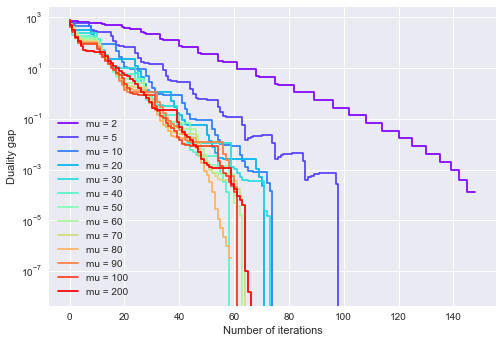

In [6]:
# Experiment

lambda_ = 10
n, d = 100, 200
mus = [2,5,10,20,30,40,50,60,70,80,90,100,200]

w, solutions = plot_all(mus=mus, d=d, n=n, lambda_=lambda_)

$\rightarrow$ $\mu = 80$ seems to be the ideal value here.

As it is shown in the figure below, the value of $\mu$ does not impact how the barrier method recovers $w$.

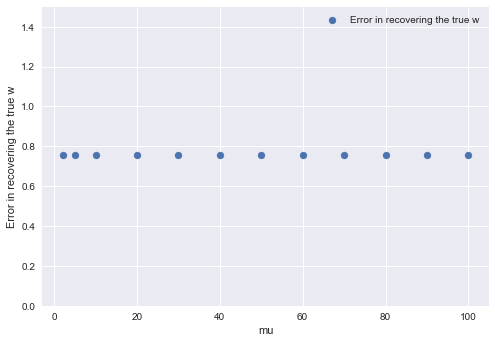

In [7]:
# Plot the error as a function of mu

plt.scatter(mus[:-1],[np.linalg.norm(sol - w)/np.linalg.norm(w) for sol in solutions["w"]][:-1], label="Error in recovering the true w");
plt.ylim((0,1.5));
plt.xlabel("mu");
plt.ylabel("Error in recovering the true w");
plt.legend();